### Data Exploration Notebook

In [1]:
# Import standard libraries
import os
import sys
import logging

# Add the project root directory to sys.path
project_root = os.path.abspath(os.path.join('..'))
sys.path.append(project_root)

# Import third-party libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter
from datetime import datetime

# Import local modules
from src.data.data_preprocessing import clean_duplicated_timestamps
from src.analysis.exploratory_analysis import (
    plot_basic_plant_measurements,
    plot_comparison,
    plot_col,
    plot_condition_pie_chart)
from src.utils.constants import CONDITION_DICT, CONDITION_DICT_TEXT_F

# Configure logging
logger = logging.getLogger(__name__)
logger.info("Environment setup completed.")

2025-02-06 20:55:52,421 - INFO - Environment setup completed.


In [20]:
#Load the Dataset
file_path = os.path.join(project_root, 'data', 'processed', 'preprocessed_data_20250206_171406.parquet')
df = pd.read_parquet(file_path)

# Display basic information
print(f"Dataset loaded successfully with shape: {df.shape}")
df.head()

Dataset loaded successfully with shape: (5991840, 18)


s4  wsrh  wstemp  wspar  vpd  gh_ID  exp_ID plant_ID  \
timestamp                                                                       
2018-07-06 00:00:00 6624.08 85.50   26.50   0.00 0.52      3      13     1002   
2018-07-06 00:03:00 6628.62 85.50   26.33   0.00 0.49      3      13     1002   
2018-07-06 00:06:00 6630.63 85.50   26.18   0.00 0.49      3      13     1002   
2018-07-06 00:09:00 6629.12 85.60   26.07   0.00 0.48      3      13     1002   
2018-07-06 00:12:00 6625.50 85.70   26.02   0.00 0.48      3      13     1002   

                    plant_type soil_sand  Weight_change condition     dt  \
timestamp                                                                  
2018-07-06 00:00:00     Tomato      sand            NaN         W 102.80   
2018-07-06 00:03:00     Tomato      sand          49.78         W    NaN   
2018-07-06 00:06:00     Tomato      sand         -20.93         W    NaN   
2018-07-06 00:09:00     Tomato      sand          -6.43         W    NaN   
2018-07-06 00:12:00     Tomato      sand          -4.05         W    NaN   

                     unique_id  s4_outlier  growth   pnw  transpiration  
timestamp                                                                
2018-07-06 00:00:00  1002_13_3       False    0.00 43.80          -2.00  
2018-07-06 00:03:00  1002_13_3       False    0.00 43.80          -1.06  
2018-07-06 00:06:00  1002_13_3       False    0.00 43.80          -0.11  
2018-07-06 00:09:00  1002_13_3       False    0.00 43.80           0.61  
2018-07-06 00:12:00  1002_13_3       False    0.00 43.81           0.98

In [21]:
df.unique_id.nunique()

496

In [22]:
df = clean_duplicated_timestamps(df)

2025-02-06 20:56:34,523 - INFO - Duplicate cleaning process completed successfully.


In [23]:
# Filter the DataFrame to include only entries between 4 AM and 8 PM
df['dt'] = df['dt'].ffill(limit=480) #copy dt to the whole day
df_filtered = df.between_time('04:00', '20:00', inclusive="left") #interval includes the start time but excludes the end time so it would be a round number of observations.

In [24]:
# Data Types and Column Overview
print("\nData Types:")
print(df_filtered.dtypes)


Data Types:
s4               float64
wsrh             float64
wstemp           float64
wspar            float64
vpd              float64
gh_ID              int64
exp_ID             int64
plant_ID          object
plant_type        object
soil_sand         object
Weight_change    float64
condition         object
dt               float64
unique_id         object
s4_outlier          bool
growth           float64
pnw              float64
transpiration    float64
dtype: object


In [25]:
# Basic statistics
print("\nSummary Statistics:")
# Modify display options to remove 'e' from scientific notation
pd.set_option('display.float_format', lambda x: '%.2f' % x)

#look at data
df_filtered.describe(include='all')


Summary Statistics:


s4       wsrh     wstemp      wspar        vpd      gh_ID  \
count  3992246.00 3993468.00 3993552.00 3976428.00 3993468.00 3994560.00   
unique        NaN        NaN        NaN        NaN        NaN        NaN   
top           NaN        NaN        NaN        NaN        NaN        NaN   
freq          NaN        NaN        NaN        NaN        NaN        NaN   
mean      5870.54      61.68      20.77     263.27       1.11       9.26   
std       1438.50      19.65       6.78     305.86       0.81      11.97   
min       1103.48       5.90       4.00       0.00       0.02       3.00   
25%       5638.57      46.70      15.00       0.00       0.42       3.00   
50%       6315.74      62.70      21.00     136.00       1.02       3.00   
75%       6830.82      78.30      26.98     461.00       1.61       3.00   
max       8805.50      98.70      42.00    1512.00       6.50      33.00   

           exp_ID plant_ID plant_type soil_sand  Weight_change condition  \
count  3994560.00  3994560    3994560   3994560     3977160.00   3994560   
unique        NaN      496         11         3            NaN         6   
top           NaN    24759     Tomato      sand            NaN         W   
freq          NaN    21440    1963840   2933760            NaN   3312640   
mean       208.93      NaN        NaN       NaN          -0.75       NaN   
std        140.32      NaN        NaN       NaN          60.29       NaN   
min          4.00      NaN        NaN       NaN      -25150.31       NaN   
25%         83.00      NaN        NaN       NaN          -1.14       NaN   
50%        199.00      NaN        NaN       NaN          -0.43       NaN   
75%        346.00      NaN        NaN       NaN          -0.01       NaN   
max        422.00      NaN        NaN       NaN       25388.51       NaN   

               dt    unique_id s4_outlier     growth        pnw  transpiration  
count  3990080.00      3994560    3994560 3831360.00 3955200.00     3992218.00  
unique        NaN          496          2        NaN        NaN            NaN  
top           NaN  24759_417_3      False        NaN        NaN            NaN  
freq          NaN        21440    3991628        NaN        NaN            NaN  
mean       243.07          NaN        NaN       0.00     138.91           0.25  
std        264.81          NaN        NaN       0.00     150.41           0.43  
min       -758.28          NaN        NaN      -0.00       1.09         -76.14  
25%         66.73          NaN        NaN       0.00      35.94           0.03  
50%        148.89          NaN        NaN       0.00      88.77           0.11  
75%        310.63          NaN        NaN       0.00     186.77           0.31  
max       2071.21          NaN        NaN       0.00    1214.42          59.05

## Exploratory Data Analysis (EDA)

C:\Users\shani\AppData\Local\Temp\ipykernel_16412\3605100470.py:3: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



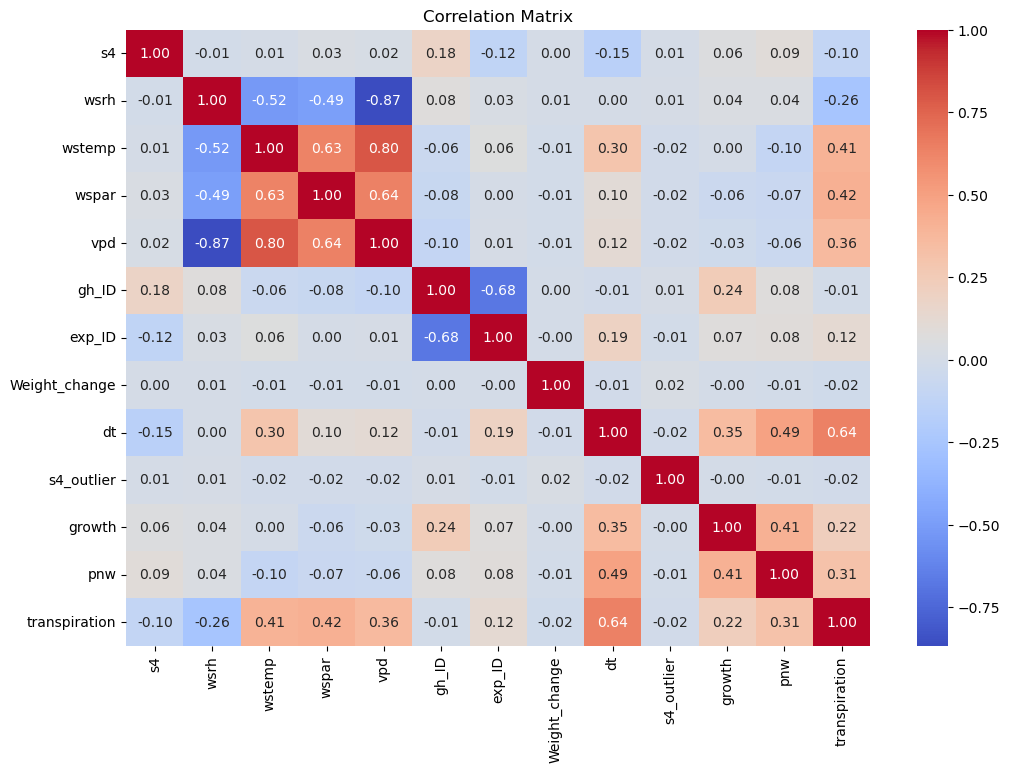

In [26]:
# Correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(df_filtered.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [9]:
#Time Series Visualization
plot_basic_plant_measurements('21662_354_3',df_filtered ,main_col='transpiration')

Info: Plot generated for plant ID: 21662_354_3


In [10]:
all_uid = list(df_filtered['unique_id'].unique())

In [11]:
for uid in all_uid:
    
    plot_comparison(uid, df ,df_filtered)

    all_uid.remove(uid)
    break


g:\My Drive\Shani Friedman\HUJI\ML\lab_git\sci-phy\src\analysis\exploratory_analysis.py:51: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Info: Comparison plot generated for plant ID: 1002_13_3


In [12]:
random_unique_id = np.random.choice(df_filtered['unique_id'].unique())
plot_col(random_unique_id, df_filtered,'transpiration')

Plot generated for plant ID: 1121_33_33


## Condition-wise Analysis

In [13]:
df_filtered.condition.unique()

array(['W', 'S', 'DP', 'C', 'DT', 'B'], dtype=object)

In [14]:
# Group by unique_id and check if diffrent to 'W' condition is present in each group
condition_count = df_filtered.groupby('unique_id')['condition'].apply(lambda x: (x != 'W').any())

# Count how many unique IDs have not only 'W' condition
stress_condition_count = condition_count.sum()

# Calculate the percentage
percentage_with_stress = (stress_condition_count / len(condition_count)) * 100

print(f"Percentage of unique IDs with a streess condition: {percentage_with_stress}%")

Percentage of unique IDs with a streess condition: 26.209677419354836%


In [15]:
salt_exp = list(df_filtered[df_filtered['condition'] == 'S']['exp_ID'].unique())
salt_exp

[189, 36, 267, 393]

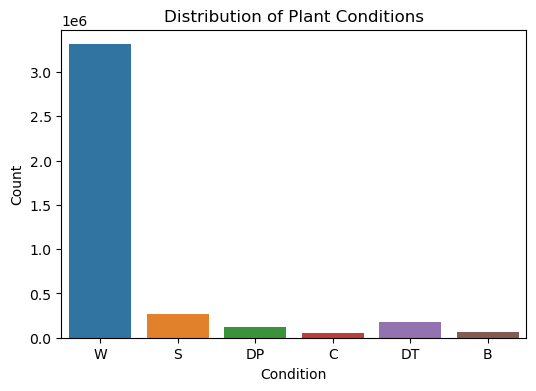

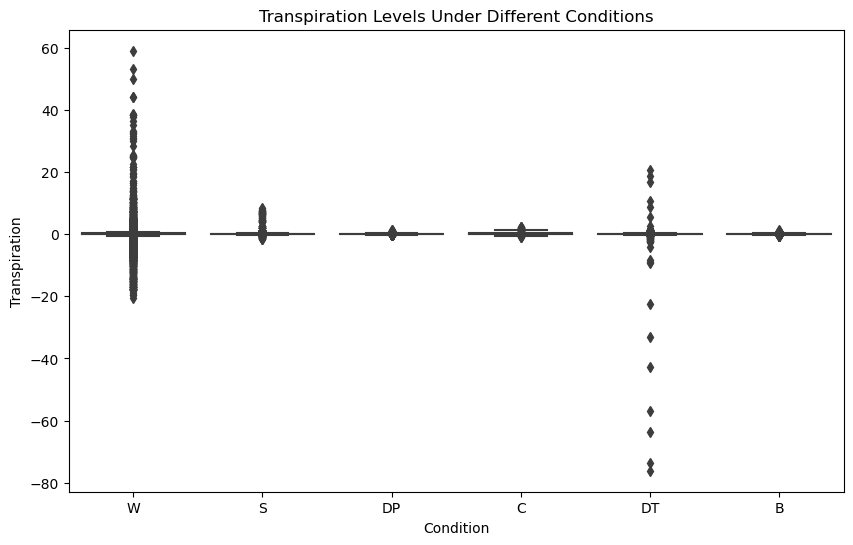

In [16]:
# Condition-wise Analysis
# Distribution of conditions
plt.figure(figsize=(6, 4))
sns.countplot(x='condition', data=df_filtered)
plt.title('Distribution of Plant Conditions')
plt.xlabel('Condition')
plt.ylabel('Count')
plt.show()

# Compare transpiration under different conditions
plt.figure(figsize=(10, 6))
sns.boxplot(x='condition', y='transpiration', data=df_filtered)
plt.title('Transpiration Levels Under Different Conditions')
plt.xlabel('Condition')
plt.ylabel('Transpiration')
plt.show()

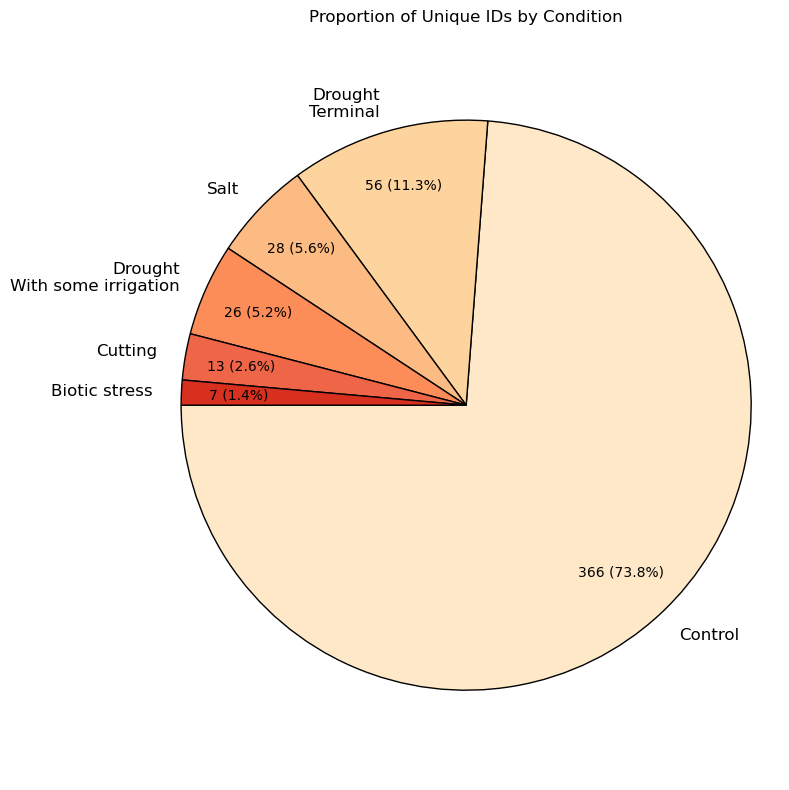

In [ ]:
plot_condition_pie_chart(df_filtered, CONDITION_DICT_TEXT_F)

## save modifications

In [ ]:
# Save any modifications to a new file
cleaned_file_path = os.path.join(project_root, 'data', 'processed', 'cleaned_final_data.parquet')
df_filtered.to_parquet(cleaned_file_path, index=False)

print(f"Cleaned data saved to {cleaned_file_path}")